## Echo top height detection algorithm and comparison vs VISST

This notebook detects echo top heights in regions covered by DCCs. 
It will look at the maximum height where Z > 1 dBZ.

In [5]:
import pyart
from matplotlib import pyplot as plt
%matplotlib inline
from copy import deepcopy
import numpy as np
import math
from mpl_toolkits.basemap import Basemap
from scipy import ndimage, interpolate, signal
from netCDF4 import Dataset
from matplotlib import dates
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import datetime
import glob
import pandas

In [1028]:
# Input the range of dates and time wanted for the collection of images
start_year = 2006
start_day = 8
start_month = 1
start_hour = 21
start_minute = 20
start_second = 0

end_year = 2006
end_month = 1
end_day = 8
end_hour = 23
end_minute = 0
end_second = 0

sounding = '/home/rjackson/data/soundings/twpsondewnpnC3.b1.20060120.231500.custom.cdf'
visst_image = '/home/rjackson/data/visst/twpvisstpx04m1rv1minnisX30.c1.20060120.000000.custom.cdf'
data_path = '/home/rjackson/multidop_grids/'
grid_path = '/home/rjackson/data/radar/gridded_data/cpol_200601200030.nc'
num_levels = 40

In [1029]:
# Get beam crossing angle between radars
def get_bca(grid):
    berr_origin = [-12960.1,-23091.1]
    x,y = np.meshgrid(grid.x['data'], grid.y['data'])
    a = np.sqrt(np.multiply(x,x)+np.multiply(y,y))
    b = np.sqrt(pow(x-berr_origin[0],2)+pow(y-berr_origin[1],2))
    c = np.sqrt(berr_origin[0]*berr_origin[0]+berr_origin[1]*berr_origin[1])
    theta_1 = np.arccos(x/a)
    theta_2 = np.arccos((x-berr_origin[1])/b)
    return np.arccos((a*a+b*b-c*c)/(2*a*b))

def dms_to_decimal(deg, minutes, seconds):
    return deg+minutes/60+seconds/3600

# Convert seconds to midnight to a string format
def seconds_to_midnight_to_string(time_secs_after_midnight):

    hours = math.floor(time_secs_after_midnight/3600)
    minutes = math.floor((time_secs_after_midnight - hours*3600)/60)
    temp = datetime.time(int(hours), int(minutes), )
    return temp.strftime('%H%M%S')

def seconds_to_midnight_to_hm(time_secs_after_midnight):
    hours = math.floor(time_secs_after_midnight/3600)
    minutes = math.floor((time_secs_after_midnight - hours*3600)/60)
    return hours, minutes


In [1030]:
pyart_grid = pyart.io.read_grid(grid_path)
z = pyart_grid.fields['velocity_texture']['data']
bca = np.ma.masked_invalid(bca)

grid_x = pyart_grid.point_x['data']
grid_y = pyart_grid.point_y['data']
grid_z = pyart_grid.point_z['data']

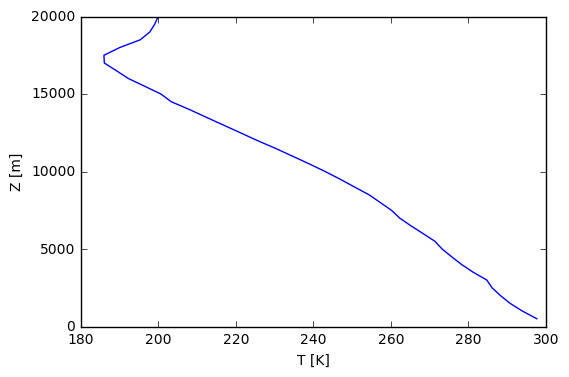

In [1031]:
Sounding_netcdf = Dataset(sounding, mode='r')
Time = Sounding_netcdf.variables['time_offset'][:]
base_time = Sounding_netcdf.variables['base_time'][:]
alt = Sounding_netcdf.variables['alt'][:]
temp = Sounding_netcdf.variables['tdry'][:]

Tz = interpolate.interp1d(alt, temp+273.15)
grid_temp = Tz(grid_z)
plt.plot(grid_temp[:,1,1], grid_z[:,1,1])
plt.xlabel('T [K]')
plt.ylabel('Z [m]')

(8991,)
(8991,)


/home/rjackson/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


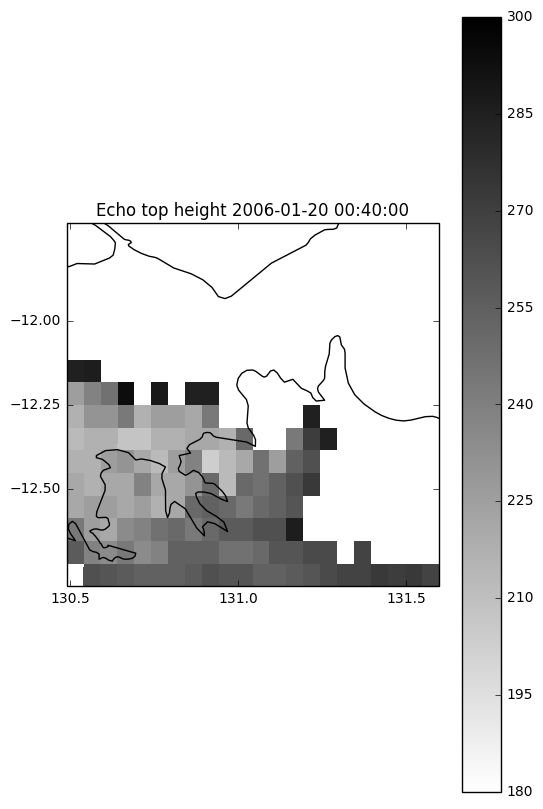

In [1044]:
# Set mask to exclude data less than 15 km from CPOL where radar does not sample top
resolution = 5
array_shape = grid_z.shape
echo_top = np.zeros((array_shape[1],array_shape[2]))
echo_temp = np.zeros((array_shape[1],array_shape[2]))
for i in range(0, array_shape[1]):
    for j in range(0, array_shape[2]):
        in_cloud = np.where(z[:,i,j] < 3)
        if(len(in_cloud[0]) > 0):
            in_cloud = in_cloud[0][-1]
            echo_top[i,j] = grid_z[in_cloud,i,j]
            echo_temp[i,j] = grid_temp[in_cloud,i,j]
        else:
            echo_top[i,j] = np.nan
            echo_temp[i,j] = np.nan
        
        if(math.sqrt(math.pow(grid_x[0,i,j],2) +
                     math.pow(grid_y[0,i,j],2)) < 15000):
            echo_top[i,j] = np.nan
            echo_temp[i,j] = np.nan
# Regrid data to multidop's grid
x = pyart_grid.point_longitude['data'][0,
                                       ::resolution, 
                                       ::resolution]
y = pyart_grid.point_latitude['data'][0,
                                      ::resolution, 
                                      ::resolution]
# Grid echo top height to coarser resolution
Lon = pyart_grid.point_longitude['data'][0]
Lat = pyart_grid.point_latitude['data'][0]
Lon = Lon.flatten()
Lat = Lat.flatten()
echo_top = echo_top.flatten()
echo_temp = echo_temp.flatten()
print(echo_top.shape)
print(Lat.shape)
echo_temp = interpolate.griddata((Lon,Lat), echo_temp, (x,y), method='linear')
plt.figure(figsize=(6,10))
plt.subplot(211)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m')

ax.set_xticks([130, 130.5, 131, 131.5, 132], crs=ccrs.PlateCarree())
ax.set_yticks([-14, -13.5, -13, -12.5, -12.25,
               -12, -11,-10.5,], crs=ccrs.PlateCarree())
plt.pcolormesh(x,
               y,
               echo_temp,
               cmap=plt.get_cmap('gray_r'))
plt.colorbar()
plt.clim([180, 300])
plt.title('Echo top height ' + str(time_to_choose))


## Compare VISST brightness temperatures vs. echo top temperatures

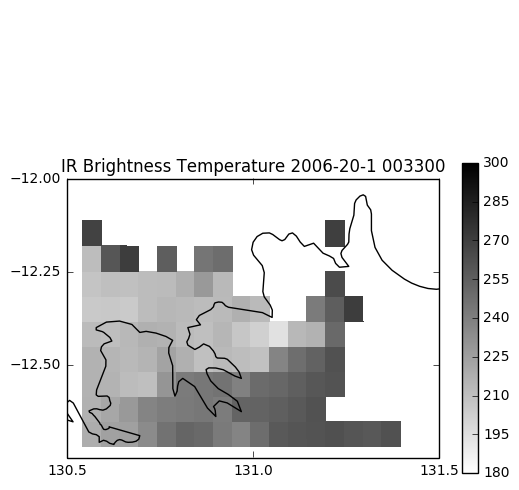

In [1033]:
i = 2
cdf_data = Dataset(visst_image, mode='r')

# Load lat, lon, and time parameters - try statement for 24-hourly data, except for daily data

Latitude = cdf_data.variables['latitude']
Longitude = cdf_data.variables['longitude']
Time = cdf_data.variables['image_times']
NumPixels = cdf_data.variables['image_numpix']
year = 2006
day = 20
month = 1
# Load brightness temperature
IRBrightness = cdf_data.variables['temperature_ir']

frame = 2

j = frame

convective_regions = IRBrightness[:] < 240
Darwin_Lat = dms_to_decimal(-12, 25, 28.56)
Darwin_Lon = dms_to_decimal(130, 53, 29.75)

cpol_latitude = -12.249166
cpol_longitude = 131.04445

# Get Lat and Lon for specific frame
Lat = Latitude[(int(j)*int(NumPixels[j])):(int(j+1)*int(NumPixels[j])-1)]
Lon = Longitude[(int(j)*int(NumPixels[j])):(int(j+1)*int(NumPixels[j])-1)]

# Set up projection
plt.clf()
m = Basemap(width=500000, height=500000,
            resolution='l', projection='stere',
            lat_0=cpol_latitude,
            lon_0=cpol_longitude)

darwin_x, darwin_y = m(cpol_latitude, cpol_longitude)

# Regrid data to multidop's grid
x = pyart_grid.point_longitude['data'][0,
                                       ::resolution, 
                                       ::resolution]
y = pyart_grid.point_latitude['data'][0,
                                      ::resolution, 
                                      ::resolution]

index = j
data = IRBrightness[(int(j)*int(NumPixels[j])):(int(j+1)*int(NumPixels[j])-1)]
data_gridded = interpolate.griddata((Lon,Lat), data, (x,y), method='nearest')
lat_gridded = interpolate.griddata((Lon,Lat), Lat, (x,y))
lon_gridded = interpolate.griddata((Lon,Lat), Lon, (x,y))
lat_bounds = np.logical_or(lat_gridded < -12.75,
                           lat_gridded > -12)
lon_bounds = np.logical_or(lon_gridded < 130.5,
                           lon_gridded > 131.5)
masked_region = np.logical_or(lat_bounds, lon_bounds)
masked_region = np.logical_or(masked_region, 
                              np.isnan(echo_temp))
data_masked = np.ma.array(data_gridded)
data_masked = np.ma.masked_where(masked_region, data_gridded)
# Plot the masked data
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m')
plt.pcolormesh(x,y,data_masked, cmap='gray_r', vmin=190, vmax=270)
plt.text(Darwin_Lon, Darwin_Lat,
         'Darwin',
         fontweight='bold',
         color='white',
         )
plt.plot(Darwin_Lon, Darwin_Lat, 'w.')
ax.set_xticks([130, 130.5, 131, 131.5, 132], crs=ccrs.PlateCarree())
ax.set_yticks([-14, -13.5, -13, -12.5, -12.25,
               -12, -11,-10.5,], crs=ccrs.PlateCarree())
ax.set_xlim([130.5, 131.5])
ax.set_ylim([-12.75, -12])
plt.clim([180, 300])
plt.title('IR Brightness Temperature '
          + str(year)
          + '-'
          + str(day)
          + '-'
          + str(month)
          + ' '
          + seconds_to_midnight_to_string(Time[frame]))
plt.colorbar()

/home/rjackson/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


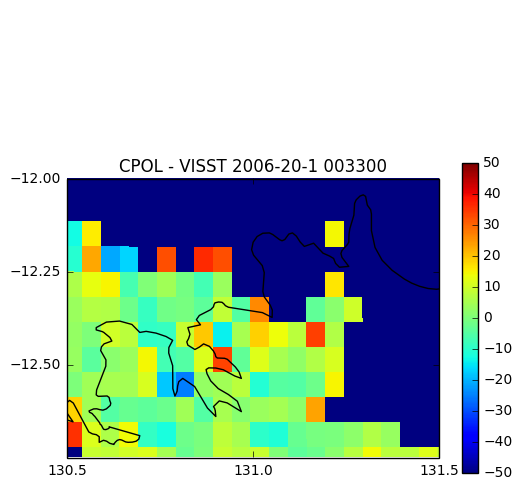

In [1034]:
# Plot the masked data
ax2 = plt.axes(projection=ccrs.PlateCarree())
ax2.coastlines(resolution='10m')
plt.pcolormesh(x,y,echo_temp-data_gridded, cmap='jet', vmin=190, vmax=270)
plt.text(Darwin_Lon, Darwin_Lat,
         'Darwin',
         fontweight='bold',
         color='white',
         )
plt.plot(Darwin_Lon, Darwin_Lat, 'w.')
ax2.set_xticks([130, 130.5, 131, 131.5, 132], crs=ccrs.PlateCarree())
ax2.set_yticks([-14, -13.5, -13, -12.5, -12.25,
               -12, -11,-10.5,], crs=ccrs.PlateCarree())
ax2.set_xlim([130.5, 131.5])
ax2.set_ylim([-12.75, -12])
plt.clim([-50, 50])
plt.title('CPOL - VISST '
          + str(year)
          + '-'
          + str(day)
          + '-'
          + str(month)
          + ' '
          + seconds_to_midnight_to_string(Time[frame]))
plt.colorbar()

/home/rjackson/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


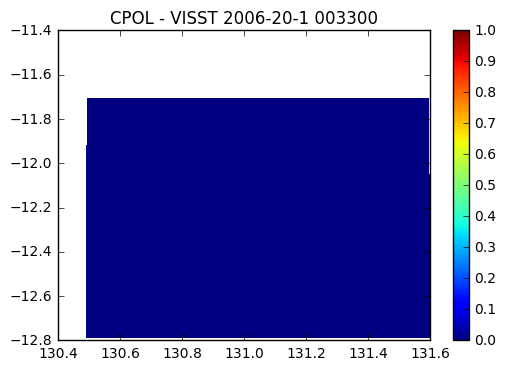

In [1035]:
corr = signal.correlate2d(echo_temp, data_gridded, boundary='symm', mode='same')
ax.coastlines(resolution='10m')
plt.pcolormesh(x,y,corr, cmap='jet', vmin=0, vmax=1)
plt.plot(Darwin_Lon, Darwin_Lat, 'w.')
ax.set_xticks([130, 130.5, 131, 131.5, 132], crs=ccrs.PlateCarree())
ax.set_yticks([-14, -13.5, -13, -12.5, -12.25,
               -12, -11,-10.5,], crs=ccrs.PlateCarree())
ax.set_xlim([130.5, 131.5])
ax.set_ylim([-12.75, -12])
plt.clim([0, 1])
plt.title('CPOL - VISST '
          + str(year)
          + '-'
          + str(day)
          + '-'
          + str(month)
          + ' '
          + seconds_to_midnight_to_string(Time[frame]))
plt.colorbar()

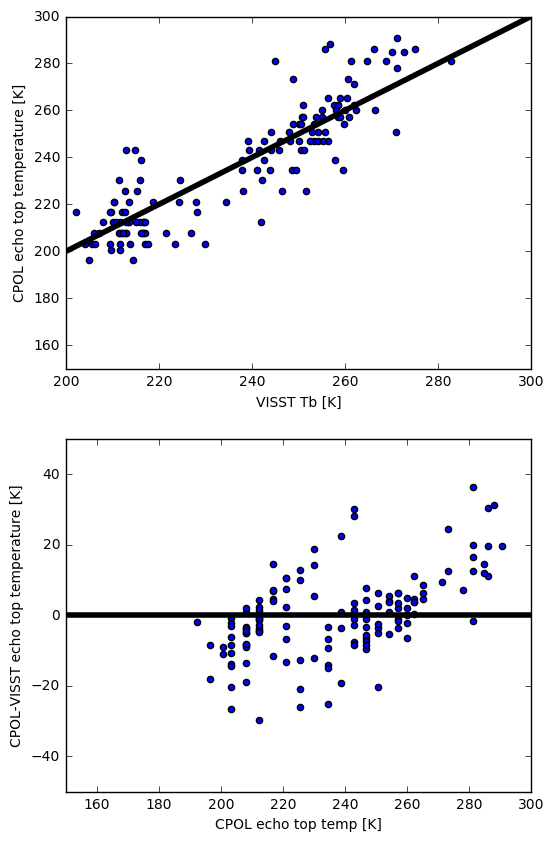

In [1042]:
plt.figure(figsize=(6,10))
plt.subplot(211)
plt.scatter(data_gridded, echo_temp)
plt.plot([1, 300], [1, 300], linewidth=4, color='k')
plt.xlim([200, 300])
plt.ylim([150, 300])
plt.xlabel('VISST Tb [K]')
plt.ylabel('CPOL echo top temperature [K]')

plt.subplot(212)
plt.scatter(echo_temp, echo_temp-data_gridded)
plt.plot([150, 300], [0, 0], linewidth=4, color='k')
plt.xlim([150, 300])
plt.ylim([-50, 50])
plt.xlabel('CPOL echo top temp [K]')
plt.ylabel('CPOL-VISST echo top temperature [K]')

/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in less_equal
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in less_equal
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in greater_equal
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in less


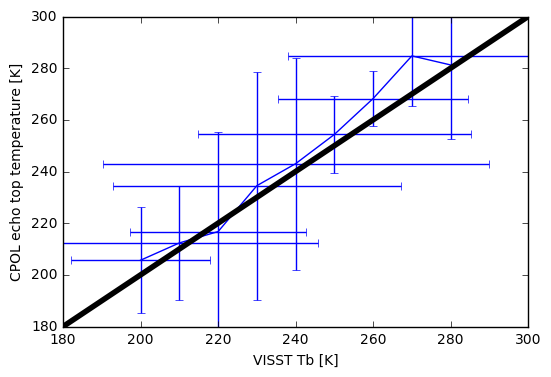

In [1043]:
tb_delta = 10
avg_bins = np.arange(200, 300, tb_delta)
quartiles_x = np.zeros((len(avg_bins)-1,3))
quartiles_y = np.zeros((len(avg_bins)-1,3))
data_gridded[np.logical_or(data_gridded <= 0,
                           echo_temp <= 0)] = np.nan
echo_temp[np.logical_or(data_gridded <= 0,
                        echo_temp <= 0)] = np.nan
for i in range(0, len(avg_bins)-1):
    x_restrictions = np.logical_and(data_gridded >= avg_bins[i],
                                    data_gridded < avg_bins[i+1])
    y_restrictions = np.logical_and(echo_temp >= avg_bins[i],
                                    echo_temp < avg_bins[i+1])
    quartiles_y[i,:] = np.nanpercentile(echo_temp[x_restrictions],
                                        [5, 50, 95])
    quartiles_x[i,:] = np.nanpercentile(data_gridded[y_restrictions],
                                        [5, 50, 95])

plt.errorbar(avg_bins[:-1], 
             quartiles_y[:,1], 
             xerr=quartiles_y[:,2]-quartiles_y[:,0],
             yerr=quartiles_x[:,2]-quartiles_x[:,0])
plt.plot([1, 300], [1, 300], linewidth=4, color='k')
plt.xlim([180, 300])
plt.ylim([180, 300])   
plt.xlabel('VISST Tb [K]')
plt.ylabel('CPOL echo top temperature [K]')

## Echo top heights CPOL vs VISST for 2 months during TWP-ICE

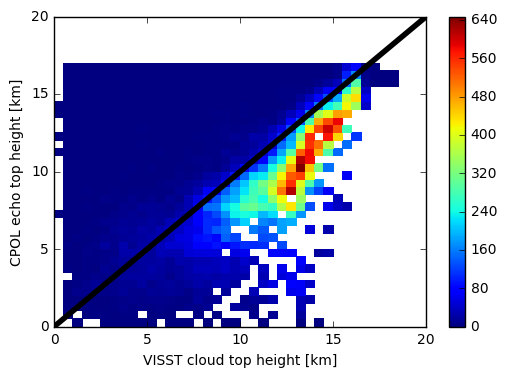

In [60]:
ncdataset = Dataset('/home/rjackson/data/echo_top_heights_TWP-ICE-Texturegt3-5km.cdf',
                    mode='r')
# Load Drosdowsky
drosdowsky_file = '/home/rjackson/data/Drosdowsky.cdf'
mjo_index_file = '/home/rjackson/data/rmm.74toRealtime.txt'
dros_dataset = Dataset(drosdowsky_file, mode='r')


cpol_T = ncdataset.variables['cpol_T_echo_top'][:]
visst_Tv = ncdataset.variables['visst_Tv'][:]
years = ncdataset.variables['year'][:]
months = ncdataset.variables['month'][:]
days = ncdataset.variables['day'][:]
hours = ncdataset.variables['hour'][:]
minutes = ncdataset.variables['minute'][:]
seconds = ncdataset.variables['second'][:]

year_p = dros_dataset.variables['year'][:]
month_p = dros_dataset.variables['month'][:]
day_p = dros_dataset.variables['day'][:]
groups_p = dros_dataset.variables['groups'][:]

groups_mapped_to_scp = np.zeros(len(years))
mjo_index_mapped_to_scp = np.zeros(len(years))
data = pandas.read_csv(mjo_index_file,
                       header=2,
                       delim_whitespace=True)
data_matrix = np.ma.array(data.values)
year = data_matrix[:,0]
month = data_matrix[:,1]
day = data_matrix[:,2]
mjo = data_matrix[:,5]
mjo[mjo > 99].mask = True

for i in range(0, len(years)):
    index = np.logical_and(year_p == years[i], 
                           np.logical_and(month_p == months[i],  
                                          day_p == days[i]))
    index = np.where(index == True)
    index = index[0]
    if(len(index) > 0):
        groups_mapped_to_scp[i] = groups_p[index[0]]
    else:
        groups_mapped_to_scp[i] = float('nan') 
    index = np.logical_and(year == years[i], 
                           np.logical_and(month == months[i],  
                                          day == days[i])) 
    index = np.where(index == True)
    index = index[0]
    if(len(index) > 0):
        mjo_index_mapped_to_scp[i] = mjo[index[0]]
    else:
        mjo_index_mapped_to_scp[i] = float('nan') 
        
range_excluded = np.logical_or(cpol_T < 0,
                               cpol_T > 20)
visst_range_excluded = np.logical_or(visst_Tv <= 0,
                                     visst_Tv >= 25)
cpol_T[np.logical_or(range_excluded,
                     visst_range_excluded)] = np.nan
visst_Tv[np.logical_or(range_excluded,
                       visst_range_excluded)] = np.nan
tb_delta = 0.5
avg_bins = np.arange(0, 25, tb_delta)
quartiles = np.zeros((len(avg_bins)-1,3))

array1 = visst_Tv[np.logical_and(~np.isnan(visst_Tv),
                                 ~np.isnan(cpol_T))]
array2 = cpol_T[np.logical_and(~np.isnan(visst_Tv),
                                 ~np.isnan(cpol_T))]
hist, bins1, bins2 = np.histogram2d(array1.flatten(), 
                                    array2.flatten(), 
                                    bins=avg_bins, normed=False)
bins1_grid, bins2_grid = np.meshgrid(bins1, bins2)
hist = np.ma.masked_where(hist == 0, np.transpose(hist))
plt.pcolormesh(bins1_grid, bins2_grid, hist, cmap='jet')
plt.plot([0, 20], [0, 20], linewidth=4, color='k')
plt.xlim([0, 20])
plt.ylim([0, 20])  
plt.xlabel('VISST cloud top height [km]')
plt.ylabel('CPOL echo top height [km]')
plt.colorbar()

/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  war

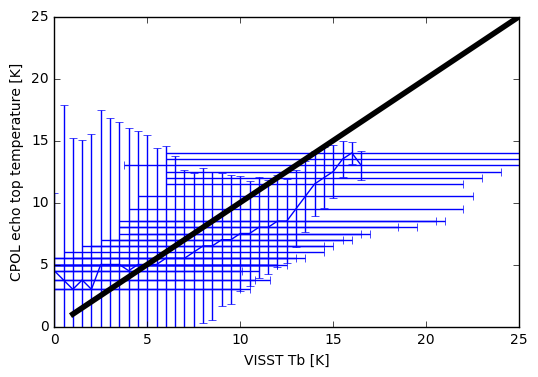

In [61]:
datenums = []
visst_Tvm = []
cpol_Tm = []

tb_delta= 5.0
quartiles_x = np.zeros((len(avg_bins)-1,3))
quartiles_y = np.zeros((len(avg_bins)-1,3))
for i in range(0, len(avg_bins)-1):
    x_restrictions = np.logical_and(visst_Tv >= avg_bins[i],
                                    visst_Tv < avg_bins[i+1])
    y_restrictions = np.logical_and(cpol_T >= avg_bins[i],
                                    cpol_T < avg_bins[i+1])
    quartiles_y[i,:] = np.nanpercentile(cpol_T[x_restrictions],
                                        [5, 50, 95])
    quartiles_x[i,:] = np.nanpercentile(visst_Tv[y_restrictions],
                                        [5, 50, 95])

plt.errorbar(avg_bins[:-1], 
             quartiles_y[:,1], 
             xerr=quartiles_y[:,2]-quartiles_y[:,0],
             yerr=quartiles_x[:,2]-quartiles_x[:,0])
plt.plot([1, 300], [1, 300], linewidth=4, color='k')
plt.xlim([0, 25])
plt.ylim([0, 25])   
plt.xlabel('VISST Tb [K]')
plt.ylabel('CPOL echo top temperature [K]')

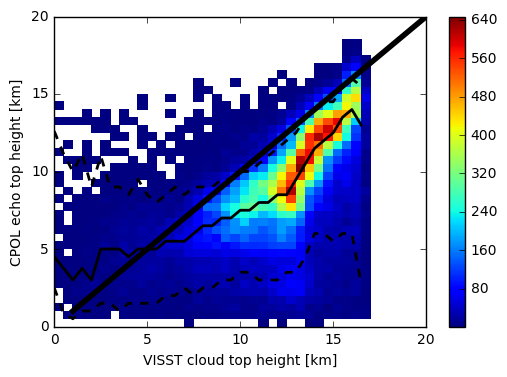

In [62]:
array1 = visst_Tv[np.logical_and(~np.isnan(visst_Tv),
                                 ~np.isnan(cpol_T))]
array2 = cpol_T[np.logical_and(~np.isnan(visst_Tv),
                                 ~np.isnan(cpol_T))]
tb_delta = 0.5
avg_bins = np.arange(0, 25, tb_delta)
hist, bins_x, bins_y = np.histogram2d(array1.flatten(), 
                                      array2.flatten(), 
                                      bins=[avg_bins,avg_bins], normed=False)

bins1_grid, bins2_grid = np.meshgrid(bins_x, bins_y)

hist = np.ma.masked_where(hist == 0, hist)
plt.pcolormesh(bins1_grid, bins2_grid, np.transpose(hist))
plt.plot(avg_bins[:-1], 
         quartiles_y[:,1], linewidth=2, color='k') 
plt.plot(avg_bins[:-1], 
         quartiles_y[:,2], linewidth=2, color='k', linestyle='--') 
plt.plot(avg_bins[:-1], 
         quartiles_y[:,0], linewidth=2, color='k', linestyle='--') 
plt.plot([1, 300], [1, 300], linewidth=4, color='k')
plt.xlim([0, 20])
plt.ylim([0, 20])   
plt.colorbar()

plt.xlabel('VISST cloud top height [km]')
plt.ylabel('CPOL echo top height [km]')

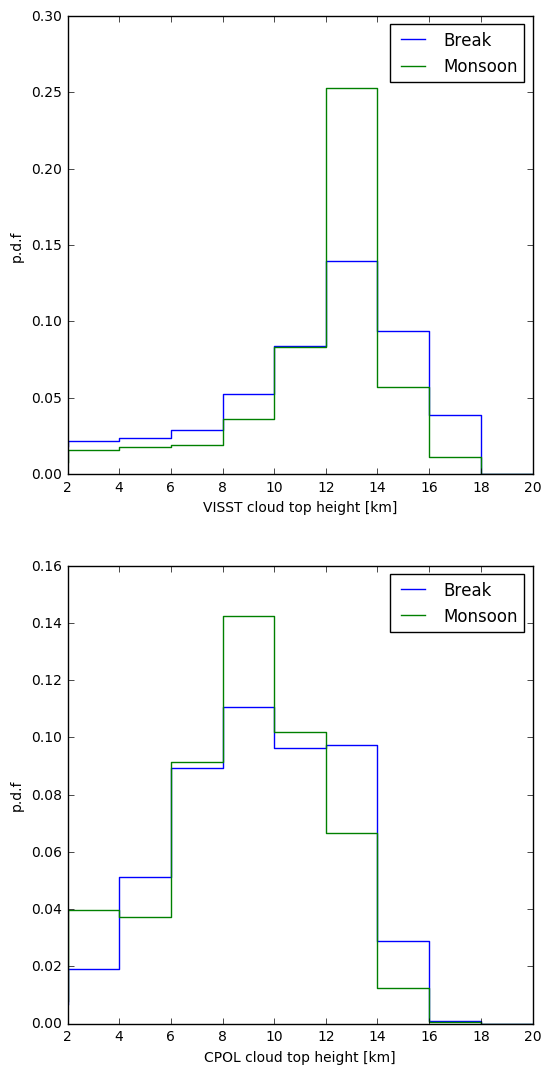

In [63]:
hist_break, bins_break = np.histogram(visst_Tv[groups_mapped_to_scp == 0,:,:], 
                                      range=[0,20],
                                      normed=True)
hist_monsoon, bins_monsoon = np.histogram(visst_Tv[groups_mapped_to_scp == 1,:,:], 
                                          range=[0,20],
                                          normed=True)
plt.figure(figsize=(6,13))
plt.subplot(211)
plt.step(bins_break[1:], hist_break)
plt.step(bins_monsoon[1:], hist_monsoon)
plt.legend(['Break', 'Monsoon'])
plt.xlabel('VISST cloud top height [km]')
plt.ylabel('p.d.f')

hist_break, bins_break = np.histogram(cpol_T[groups_mapped_to_scp == 0,:,:], 
                                      range=[0,20],
                                      normed=True)
hist_monsoon, bins_monsoon = np.histogram(cpol_T[groups_mapped_to_scp == 1,:,:], 
                                          range=[0,20],
                                          normed=True)
plt.subplot(212)
plt.step(bins_break[1:], hist_break)
plt.step(bins_monsoon[1:], hist_monsoon)
plt.legend(['Break', 'Monsoon'])
plt.xlabel('CPOL cloud top height [km]')
plt.ylabel('p.d.f')